In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

from vivarium import Artifact

!date
!whoami
!pwd

Mon Oct 27 07:39:52 PDT 2025
tylerdy
/mnt/share/homes/tylerdy/vivarium_research_alzheimers


In [ ]:
age_mapping = pd.read_csv(f"../age_bins.csv")  # downloaded with a different environment
# using vivarium_inputs.utility_data.get_age_bins;
# see also https://shiny.ihme.washington.edu/content/273/
# TODO: refactor this so that it does not require an extra .csv file
age_mapping

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,5,5,0 to 5,0.0,5.0
1,6,6,5 to 9,5.0,10.0
2,7,7,10 to 14,10.0,15.0
3,8,8,15 to 19,15.0,20.0
4,9,9,20 to 24,20.0,25.0
5,10,10,25 to 29,25.0,30.0
6,11,11,30 to 34,30.0,35.0
7,12,12,35 to 39,35.0,40.0
8,13,13,40 to 44,40.0,45.0
9,14,14,45 to 49,45.0,50.0


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [ ]:
# %cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [45]:
locations = [
    "united_states_of_america",
    #              'china',
    #              'brazil',
    #              'japan',
    #             'United_States_Of_America',
    #              'united_kingdom',
]


results_dirs = [
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.0/united_states_of_america/2025_10_24_09_08_30/results/"
]

artifact_dirs = [
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/consistent-rates/united_states_of_america.hdf"
]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/consistent-rates/united_states_of_america.hdf']

In [5]:
[x for x in os.listdir(results_dirs[0]) if "parquet" in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [6]:
# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

age_dictionary = age_mapping.copy()
age_dictionary["age_group"] = age_dictionary.age_group_name.str.lower().str.replace(
    " ", "_"
)
age_dictionary

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end,age_group
0,5,5,0 to 5,0.0,5.0,0_to_5
1,6,6,5 to 9,5.0,10.0,5_to_9
2,7,7,10 to 14,10.0,15.0,10_to_14
3,8,8,15 to 19,15.0,20.0,15_to_19
4,9,9,20 to 24,20.0,25.0,20_to_24
5,10,10,25 to 29,25.0,30.0,25_to_29
6,11,11,30 to 34,30.0,35.0,30_to_34
7,12,12,35 to 39,35.0,40.0,35_to_39
8,13,13,40 to 44,40.0,45.0,40_to_44
9,14,14,45 to 49,45.0,50.0,45_to_49


In [7]:
age_group_ids = age_dictionary.query(
    "age_start >= 30 and age_start <= 95"
).age_group_id.values

## Verify that all simulants in the model have AD 

In [8]:
def load_df(measure):
    data = pd.DataFrame()
    #     import pdb; pdb.set_trace()
    for results_dir in results_dirs:
        temp = pd.read_parquet(
            results_dir + measure + ".parquet",
            #                                filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf')],
            #                                nrows=1000
        )
        # just look at the baseline scenario for v&v purposes
        temp = temp[temp.scenario == "baseline"]

        # aggregate by summing value column over random seeds
        #         print(temp.columns)
        #         import pdb; pdb.set_trace()
        cols = [
            c
            for c in temp.columns
            if c not in ["value", "random_seed", "treatment", "artifact_path"]
        ]
        temp = temp.groupby(cols)["value"].sum().reset_index()

        temp["location"] = locations[results_dirs.index(results_dir)].title()
        temp["event_year"] = temp["event_year"].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [11]:
person_time = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,2,0.000000,United_States_Of_America
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,13,0.000000,United_States_Of_America
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,24,0.000000,United_States_Of_America
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,41,0.000000,United_States_Of_America
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,46,0.000000,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...
4274995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,446,0.000000,United_States_Of_America
4274996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,457,0.000000,United_States_Of_America
4274997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,460,0.000000,United_States_Of_America
4274998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2100,Male,499,baseline,480,0.000000,United_States_Of_America


In [12]:
person_time.loc[
    person_time.sub_entity == "susceptible_to_alzheimers_disease_and_other_dementias"
].value.sum()

0.0

In [13]:
assert (
    person_time.loc[
        person_time.sub_entity
        == "susceptible_to_alzheimers_disease_and_other_dementias"
    ].value.sum()
    == 0
), "should be zero years of person-time susceptible"

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [14]:
person_time.groupby("sub_entity").value.sum()

/tmp/ipykernel_800788/2876506740.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby("sub_entity").value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        1.434889e+08
alzheimers_disease_state                      1.318983e+08
alzheimers_mild_cognitive_impairment_state    6.679470e+07
Name: value, dtype: float64

In [15]:
person_time.groupby(
    ["location", "event_year", "age_group", "sub_entity"]
).value.sum().unstack()

/tmp/ipykernel_800788/1677760363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(


sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                                 0.000000   
                                    30_to_34                              1497.357974   
                                    35_to_39                              2051.953457   
                                    40_to_44                              2384.810404   
                                    45_to_49                              6698.995209   
...                                                                               ...   
                         2100       75_to_79                            347921.713895   
                                    80_to_84                            458363.449692   
                                    85_to_89                            408871.408624   
                                    90_to_94                            218581.875428   
                                    95_plus                              77908.955510   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
United_States_Of_America 2025       25_to_29                   0.000000   
                                    30_to_34                  83.214237   
                                    35_to_39                  62.784394   
                                    40_to_44                  47.337440   
                                    45_to_49                 127.063655   
...                                                                 ...   
                         2100       75_to_79              269987.345654   
                                    80_to_84              423079.118412   
                                    85_to_89              480716.188912   
                                    90_to_94              328496.421629   
                                    95_plus               141128.355921   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                     0.000000  
                                    30_to_34                                  1210.841889  
                                    35_to_39                                   829.152635  
                                    40_to_44                                   889.943874  
                                    45_to_49                                  2034.015058  
...                                                                                   ...  
                         2100       75_to_79                                155535.381246  
                                    80_to_84                                211251.049966  
                                    85_to_89                                195057.659138  
                                    90_to_94                                111720.344969  
                                    95_plus                                  43914.195756  

[1140 rows x 3 columns]

In [24]:
assert np.all(
    person_time[~person_time.age_group.isin(["25_to_29", "30_to_34", "35_to_40"])]
    .groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
    .fillna(0)
    > 0
)

/tmp/ipykernel_800788/491859164.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["location", "event_year", "age_group", "sub_entity"])


AssertionError: 

## Verify that there are no transitions out of susceptible state during the simulation 

In [25]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
trans.loc[
    trans.sub_entity
    == "susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias"
].value.sum()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


0.0

In [26]:
assert (
    trans.loc[
        trans.sub_entity
        == "susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias"
    ].value.sum()
    == 0
), "should be zero transitions from susceptible to with-condition"

# And that there *are* transitions out of other states for all ages

In [27]:
assert np.all(
    trans.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
    > 0
)

/tmp/ipykernel_800788/2473504446.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans.groupby(["location", "event_year", "age_group", "sub_entity"])


AssertionError: 

## Next look at the transition rates and approximate durations for BBBM and MCI

In [28]:
out_counts = (
    trans.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_counts.columns = [c.split("_to_")[0] for c in out_counts.columns]
out_counts

/tmp/ipykernel_800788/3292819502.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans.groupby(["location", "event_year", "age_group", "sub_entity"])


alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                                      0.0   
                                    30_to_34                                    113.0   
                                    35_to_39                                    150.0   
                                    40_to_44                                    167.0   
                                    45_to_49                                    504.0   
...                                                                               ...   
                         2100       75_to_79                                  26782.0   
                                    80_to_84                                  35738.0   
                                    85_to_89                                  32943.0   
                                    90_to_94                                  17997.0   
                                    95_plus                                    6663.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                          0.0  
                                    30_to_34                                        329.0  
                                    35_to_39                                        215.0  
                                    40_to_44                                        219.0  
                                    45_to_49                                        515.0  
...                                                                                   ...  
                         2100       75_to_79                                      39975.0  
                                    80_to_84                                      53867.0  
                                    85_to_89                                      48909.0  
                                    90_to_94                                      26725.0  
                                    95_plus                                        9948.0  

[1140 rows x 2 columns]

In [29]:
out_rates = (
    out_counts
    / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_rates["alzheimers_blood_based_biomarker_state"].unstack()

/tmp/ipykernel_800788/2654564655.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


age_group                            25_to_29  30_to_34  35_to_39  40_to_44  \
location                 event_year                                           
United_States_Of_America 2025             NaN  0.075466  0.073101  0.070027   
                         2026             NaN  0.077224  0.080755  0.063512   
                         2027             NaN  0.091568  0.075906  0.067463   
                         2028             NaN  0.117882  0.103346  0.068503   
                         2029             NaN  0.099105  0.104647  0.066758   
...                                       ...       ...       ...       ...   
                         2096             NaN       NaN       NaN  0.062328   
                         2097             NaN       NaN  0.000000  0.063482   
                         2098             NaN       NaN  0.000000  0.059560   
                         2099             NaN       NaN  0.286695  0.059511   
                         2100             NaN       NaN  0.000000  0.075680   

age_group                            45_to_49  50_to_54  55_to_59  60_to_64  \
location                 event_year                                           
United_States_Of_America 2025        0.075235  0.071543  0.074576  0.072640   
                         2026        0.074863  0.072833  0.077433  0.074597   
                         2027        0.076281  0.078341  0.075845  0.075213   
                         2028        0.075154  0.084612  0.075409  0.073698   
                         2029        0.078427  0.076111  0.078225  0.073991   
...                                       ...       ...       ...       ...   
                         2096        0.080131  0.083226  0.075552  0.075214   
                         2097        0.072205  0.082384  0.076525  0.077165   
                         2098        0.081455  0.084046  0.080388  0.074773   
                         2099        0.078298  0.083674  0.078034  0.076226   
                         2100        0.075549  0.077805  0.077622  0.075915   

age_group                            65_to_69  70_to_74  75_to_79  80_to_84  \
location                 event_year                                           
United_States_Of_America 2025        0.072592  0.072831  0.072717  0.071633   
                         2026        0.075176  0.074059  0.074066  0.074632   
                         2027        0.074451  0.074634  0.075859  0.075981   
                         2028        0.075588  0.076155  0.076111  0.077210   
                         2029        0.073754  0.075916  0.076271  0.077360   
...                                       ...       ...       ...       ...   
                         2096        0.076649  0.076648  0.077263  0.077981   
                         2097        0.075306  0.077069  0.076991  0.077259   
                         2098        0.075321  0.075198  0.077203  0.078382   
                         2099        0.076788  0.075676  0.076720  0.079268   
                         2100        0.075370  0.076220  0.076977  0.077969   

age_group                            85_to_89  90_to_94   95_plus  
location                 event_year                                
United_States_Of_America 2025        0.071222  0.066720  0.065832  
                         2026        0.076055  0.072914  0.069619  
                         2027        0.076901  0.075844  0.074899  
                         2028        0.078743  0.079116  0.074736  
                         2029        0.080103  0.080230  0.079319  
...                                       ...       ...       ...  
                         2096        0.080966  0.082491  0.086322  
                         2097        0.081499  0.081592  0.085795  
                         2098        0.080503  0.081665  0.085867  
                         2099        0.081396  0.082794  0.085514  
                         2100        0.080571  0.082335  0.085523  

[76 rows x 15 columns]

In [30]:
1 / 3.85

0.2597402597402597

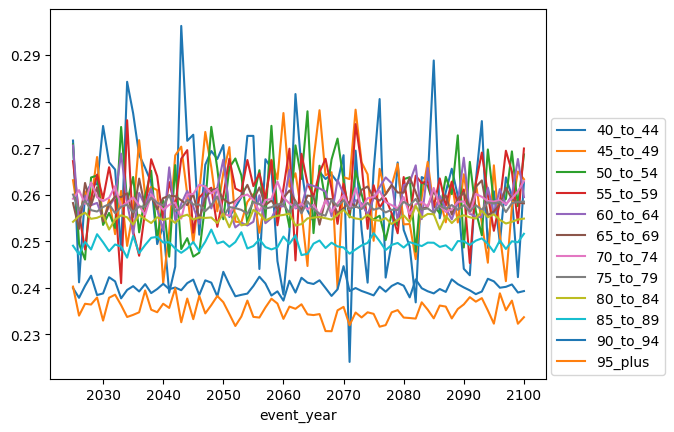

In [ ]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,3:].plot()
plt.legend(loc=(1.01, .01));

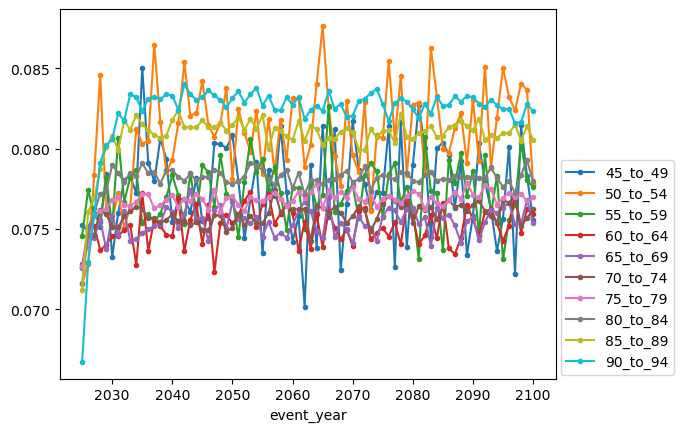

In [37]:
t = out_rates["alzheimers_blood_based_biomarker_state"].unstack()
t.loc["United_States_Of_America"].iloc[:, 4:14].plot(marker=".")
plt.legend(loc=(1.01, 0.01))

In [38]:
# prevalence \approx incidence * duration
prevalence_count = (
    person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)

mci_duration_est = (
    prevalence_count["alzheimers_mild_cognitive_impairment_state"]
    / out_counts["alzheimers_blood_based_biomarker_state"]
)
mci_duration_est

/tmp/ipykernel_800788/2467993286.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


location                  event_year  age_group
United_States_Of_America  2025        25_to_29           NaN
                                      30_to_34     10.715415
                                      35_to_39      5.527684
                                      40_to_44      5.329005
                                      45_to_49      4.035744
                                                     ...    
                          2100        75_to_79      5.807460
                                      80_to_84      5.911104
                                      85_to_89      5.921065
                                      90_to_94      6.207720
                                      95_plus       6.590754
Length: 1140, dtype: float64

In [39]:
new_sims = (
    load_df("counts_new_simulants")
    .groupby(
        [
            "location",
            "event_year",
            "age_group",
        ]
    )
    .value.sum()
)
# new_sims


bbbm_duration_est = (
    prevalence_count["alzheimers_blood_based_biomarker_state"] / new_sims
)
bbbm_duration_est

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_800788/2545667442.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(


location                  event_year  age_group
United_States_Of_America  2025        25_to_29             NaN
                                      30_to_34             inf
                                      35_to_39     2051.953457
                                      40_to_44        0.911973
                                      45_to_49        7.909085
                                                      ...     
                          2100        75_to_79        3.409961
                                      80_to_84        3.866284
                                      85_to_89        6.701931
                                      90_to_94        8.353980
                                      95_plus              inf
Length: 1140, dtype: float64

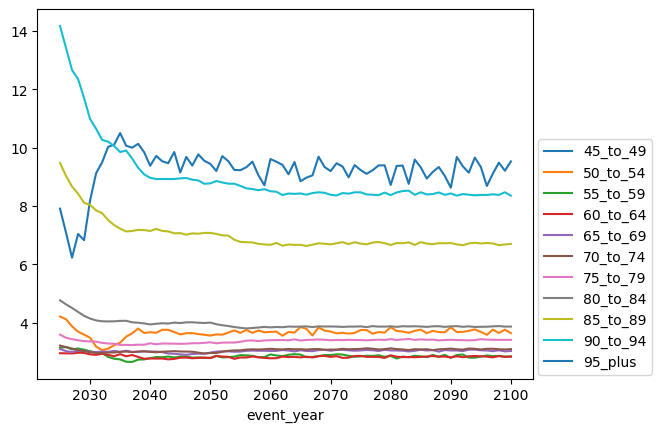

In [41]:
t = bbbm_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 4:].plot()
plt.legend(loc=(1.01, 0.01))

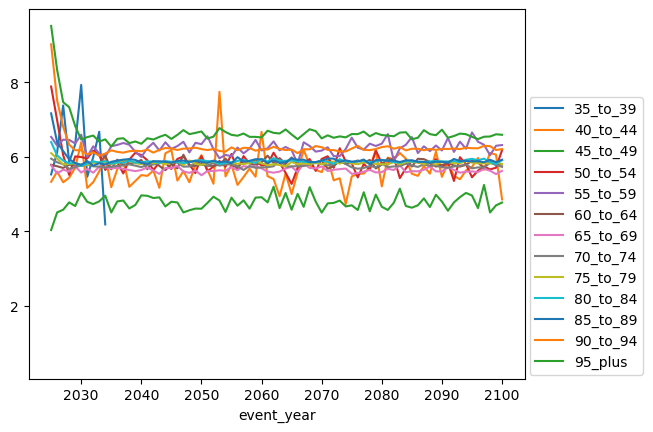

In [42]:
t = mci_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 2:].plot()
plt.legend(loc=(1.01, 0.01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [43]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id']#.isin(age_group_ids)
                     ]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:8: FutureWarning: The default of observed=False is deprecated and will be

CPU times: user 16.9 s, sys: 2.4 s, total: 19.3 s
Wall time: 17.2 s


In [46]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)

    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f"cause.all_causes.cause_specific_mortality_rate")
    b = art.load(
        f"cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
    )

    data1 = (a - b.droplevel(["year_start", "year_end"])).dropna()
    data2 = (
        data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
        .filter(["mean", "2.5%", "97.5%"])
        .reset_index()
    )
    data3 = data2.merge(age_dictionary, on=["age_start", "age_end"])
    data4 = data3  # .loc[data3['age_group_id'].isin(age_group_ids)]
    data4["measure"] = "acmr"
    data4["location"] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,Unnamed: 0,age_group_id,age_group_name,age_group,measure,location
0,Female,5.0,10.0,2022,2023,0.000095,0.000090,0.000100,6,6,5 to 9,5_to_9,acmr,United_States_Of_America
1,Female,5.0,10.0,2023,2024,0.000092,0.000088,0.000098,6,6,5 to 9,5_to_9,acmr,United_States_Of_America
2,Female,5.0,10.0,2024,2025,0.000091,0.000086,0.000097,6,6,5 to 9,5_to_9,acmr,United_States_Of_America
3,Female,5.0,10.0,2025,2026,0.000090,0.000085,0.000096,6,6,5 to 9,5_to_9,acmr,United_States_Of_America
4,Female,5.0,10.0,2026,2027,0.000089,0.000083,0.000096,6,6,5 to 9,5_to_9,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Male,95.0,125.0,2046,2047,0.255483,0.183408,0.309304,24,235,95 plus,95_plus,acmr,United_States_Of_America
1098,Male,95.0,125.0,2047,2048,0.255328,0.183463,0.309327,24,235,95 plus,95_plus,acmr,United_States_Of_America
1099,Male,95.0,125.0,2048,2049,0.255440,0.183938,0.309749,24,235,95 plus,95_plus,acmr,United_States_Of_America
1100,Male,95.0,125.0,2049,2050,0.255137,0.183684,0.310288,24,235,95 plus,95_plus,acmr,United_States_Of_America


In [47]:
art_data = art_ocmr
location = "United_States_Of_America"
sex = "Female"
year = 2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [48]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030, 2040, 2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f"C{j}"
                plot_data = sim_data.loc[
                    (sim_data.location == location)
                    & (sim_data.event_year == year)
                    & (sim_data.sex == sex)
                ]
                if art_year is None:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == year)
                    ]
                else:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == art_year)
                    ]

                ax[i].fill_between(
                    plot_data.age_start,
                    plot_data["2.5%"],
                    plot_data["97.5%"],
                    alpha=0.2,
                    color=color,
                )
                ax[i].fill_between(
                    art_plot.age_start,
                    art_plot["2.5%"],
                    art_plot["97.5%"],
                    alpha=0.2,
                    color=color,
                )

                ax[i].plot(
                    art_plot.age_start,
                    art_plot["mean"],
                    linestyle="--",
                    label=f"Artifact {sex}",
                    color=color,
                    linewidth=3,
                )
                ax[i].plot(
                    plot_data.age_start,
                    plot_data["mean"],
                    label=f"Simulation {sex}",
                    color=color,
                )

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(
                    0.5,
                    0.95,
                    f"{year}",
                    va="top",
                    ha="center",
                    transform=ax[i].transAxes,
                )
                #                 ax[i].tick_params(axis='x', labelrotation=90)

                if i == 2:
                    ax[i].set_xlabel("Age Group")

                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
        #                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)

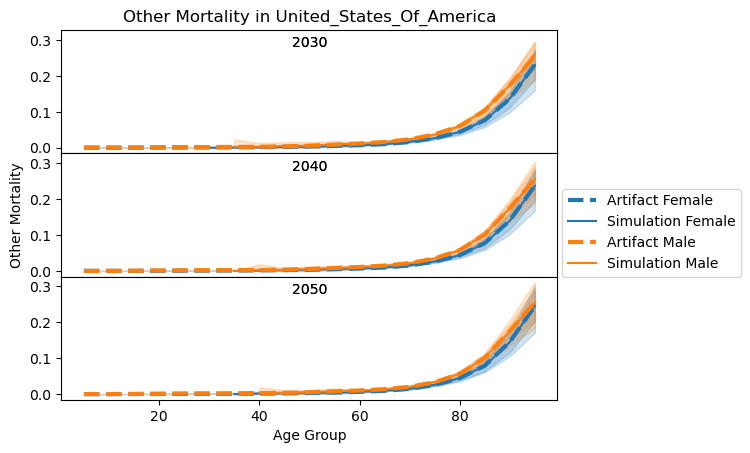

In [49]:
age_group_plot("Other Mortality", sim_ocmr, art_ocmr)

In [50]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[
                (sim_data.location == location)
                & (sim_data.age_start == age_start)
                & (sim_data.sex == sex)
            ]

            plt.plot(plot_data.event_year, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.title(
                f"{measure} in {location} Over Time Among Age Start Group {age_start}"
            )
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

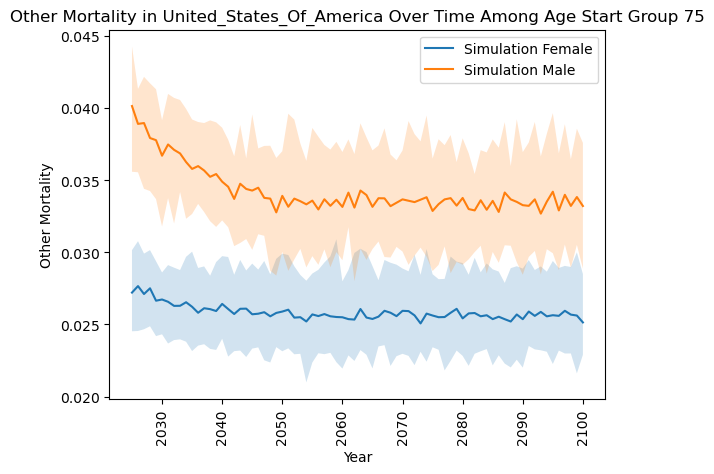

<Figure size 640x480 with 0 Axes>

In [51]:
over_time_plot("Other Mortality", sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [52]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]


def calculate_emr():
    person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
    infected = (
        person_time_total.loc[
            person_time_total.sub_entity == "alzheimers_disease_state"
        ]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(infected) > 0

    deaths0 = load_df("deaths")
    deaths = (
        deaths0.loc[deaths0.sub_entity == "alzheimers_disease_state"]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(deaths) > 0

    mr = (deaths / infected)[["value"]].reset_index()

    mr = mr.merge(age_dictionary, on=["age_group"])
    mr = mr.loc[mr["age_group_id"].isin(age_group_ids)]
    mr1 = (
        mr.groupby([c for c in cols if c != "input_draw"] + ["age_start"])
        .describe(percentiles=[0.025, 0.975])["value"]
        .reset_index()
    )
    return mr1


sim_emr = calculate_emr()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_800788/1623663996.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cols)
/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_800788/1623663996.py:18: Futur

In [53]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms=["year_start==2021"])
        data = art.load(f"cause.alzheimers_disease_and_other_dementias.{measure}")
        data = (
            data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(["mean", "2.5%", "97.5%"])
            .reset_index()
        )
        data = data.merge(age_dictionary, on=["age_start", "age_end"])
        #         data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data["measure"] = measure
        data["location"] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [54]:
art_emr = load_artifact_cause_data("excess_mortality_rate")
# art_emr

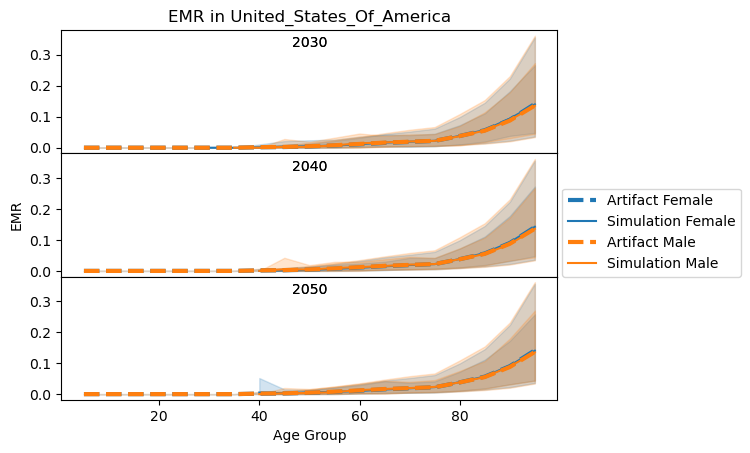

In [55]:
age_group_plot("EMR", sim_emr, art_emr, art_year=2021)

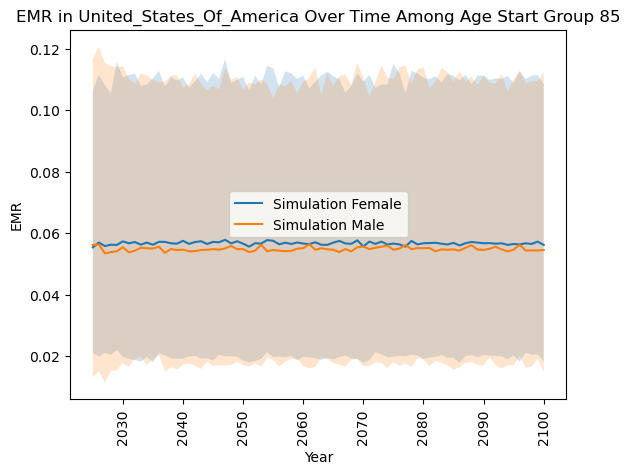

<Figure size 640x480 with 0 Axes>

In [56]:
over_time_plot("EMR", sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [57]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'covariate.live_births_by_sex.estimate',
 'population.scaling_factor',
 'cause.alzheimers.prevalence',
 'cause.alzheimers.bbbm_conditional_prevalence',
 'cause.alzheimers.mci_conditional_prevalence',
 'cause.alzheimers.mci_to_dementia_transition_rate',
 'cause.alzheimers.susceptible_to_bbbm_transition_count',
 'cause.alzheimers.population_incidence_rate',
 'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate',
 'cause.alzheimers_disease_and_other_dementias.disability_weight',
 'cause.alzheimers.mci_disability_weight',
 'cause.alzheimers_disease_and_other_dementias.restrictions',
 'testing_rates.csf',
 'testing_rates.pet',
 'treatment.

In [58]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.population_incidence_rate").droplevel(
            ["year_start", "year_end"]
        ),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_incidence_data.append(df)

art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f"draw_{i}"] *= art_incidence_data[f"draw_{i}_pop"]
    del art_incidence_data[f"draw_{i}_pop"]

In [59]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load("population.structure").reset_index()
    temp["location"] = temp.location.str.replace(" ", "_").str.title()
    #     import pdb; pdb.set_trace()
    df_prev_pop = pd.merge(
        art.load("population.scaling_factor").query("year_start == 2023"),
        art.load("population.structure")
        .query("year_start==2025")
        .droplevel(["year_start", "year_end"]),
        left_index=True,
        right_index=True,
        suffixes=["_prev", "_pop"],
    )
    prev = (
        (
            df_prev_pop.filter(like="draw_").filter(like="_prev")
            * df_prev_pop.filter(like="draw_").filter(like="_pop").values
        ).mean(axis=1)
    ).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / (prev + 0.01)
    temp["ratio"] = ratio

    temp = temp.rename(columns={"year_start": "event_year"})
    temp = temp.merge(age_dictionary, on=["age_start", "age_end"])
    temp = temp.loc[temp["age_group_id"].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [60]:
scale.groupby(
    "location"
).ratio.describe() / 5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,0.003657,6.943028e-19,0.003657,0.003657,0.003657,0.003657,0.003657


In [61]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("counts_new_simulants")
# new_sims

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


In [62]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
new_ad_dementia = trans[
    trans.sub_entity
    == "alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state"
]

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


In [63]:
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_ad_dementia = new_ad_dementia.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)

In [189]:
# new_sims

In [64]:
new_sims["total_incidence"] = new_sims["value"] / new_sims["ratio"]
new_ad_dementia["total_incidence"] = new_ad_dementia["value"] / new_sims["ratio"]


def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = (
        df.groupby([c for c in cols if c != "input_draw"])
        .describe(percentiles=[0.025, 0.975])["total_incidence"]
        .reset_index()
    )

    df = df.merge(age_dictionary, on=["age_group"])
    df = df.loc[df["age_group_id"].isin(age_group_ids)]

    return df


new_sims_summary = summarize(new_sims)

In [65]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,483.491133,322.676595,54.693567,54.693567,437.548536,1093.871341,1257.952042,11,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,236.276210,181.892089,54.693567,54.693567,164.080701,590.690524,656.322804,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,25.0,297.533005,163.380344,54.693567,54.693567,273.467835,590.690524,656.322804,12,12,35 to 39,35.0,40.0
3,2025,United_States_Of_America,35_to_39,Male,25.0,172.831672,132.737580,0.000000,0.000000,164.080701,481.303390,546.935670,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,25.0,328.161402,164.080701,0.000000,32.816140,328.161402,568.813097,601.629237,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,United_States_Of_America,85_to_89,Male,25.0,35585.822460,4983.643495,27839.025624,28167.187026,35003.882907,45384.721931,46270.757717,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,43665.156183,5033.613128,34621.027937,34916.373199,43918.934334,52297.988805,52396.437226,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,18593.625051,2263.650826,13509.311059,14887.588949,18212.957825,23069.746578,24612.105169,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,15145.742585,3312.233268,9516.680665,9680.761366,15095.424503,20006.906824,20072.539104,24,235,95 plus,95.0,125.0


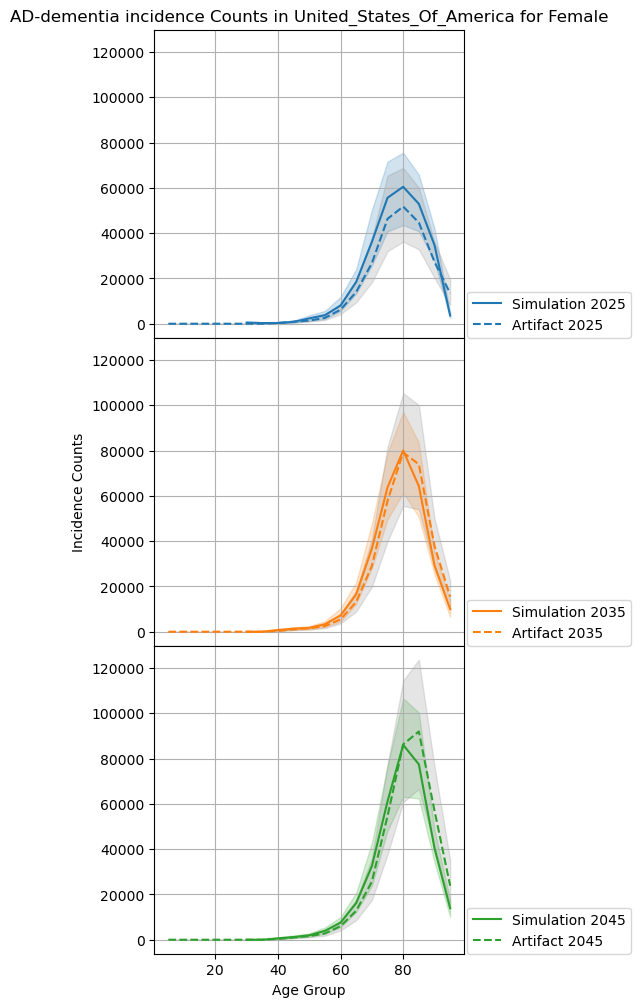

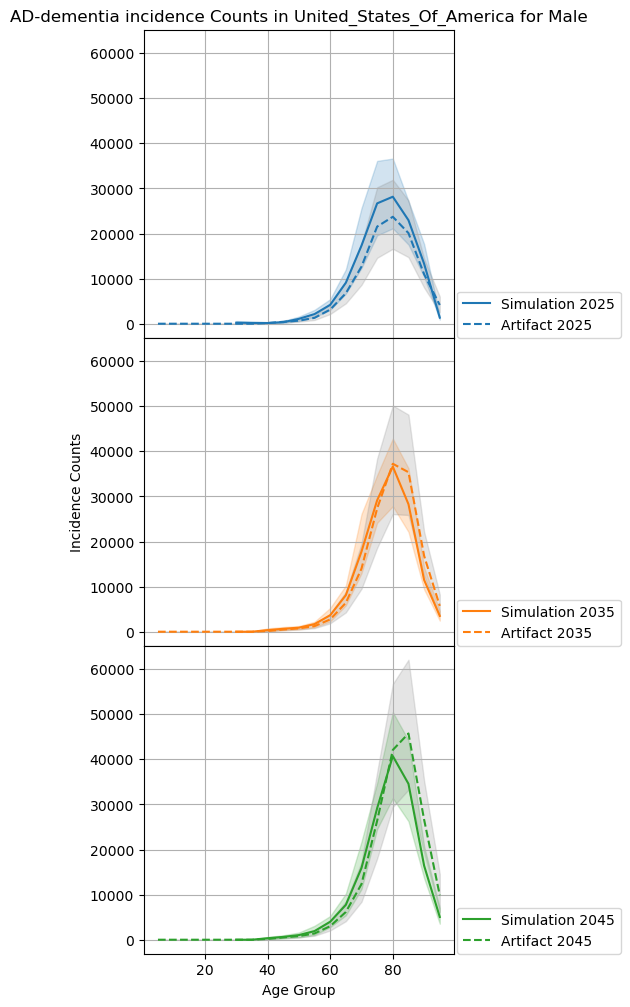

In [66]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4, 12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f"C{i}"
            plot_data = new_ad_dementia_summary.query(
                "location == @location and event_year == @year and sex == @sex"
            )

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            ax[i].fill_between(
                plot_data.age_start,
                plot_data["2.5%"],
                plot_data["97.5%"],
                alpha=0.2,
                color=color,
            )
            ax[i].fill_between(
                art_plot.age_start,
                art_plot["upper"],
                art_plot["lower"],
                alpha=0.2,
                color="grey",
            )
            ax[i].plot(
                plot_data.age_start,
                plot_data["mean"],
                label=f"Simulation {year}",
                color=color,
            )
            ax[i].plot(
                art_plot.age_start,
                art_plot["mean"],
                label=f"Artifact {year}",
                color=color,
                linestyle="--",
            )
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
            #             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))

#             ax[i].semilogy()

## Verifying Overall Prevalence

In [67]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("population.scaling_factor").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      162563.021390   
                                                  2047       2048      166675.916483   
                                                  2048       2049      170942.640904   
                                                  2049       2050      175181.374984   
                                                  2050       2051      179116.633125   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      166993.935612   
                                                  2047       2048      171817.333284   
                                                  2048       2049      176968.591455   
                                                  2049       2050      182051.190909   
                                                  2050       2051      186616.966475   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      133964.368713   
                                                  2047       2048      137691.568246   
                                                  2048       2049      141556.847175   
                                                  2049       2050      145356.075146   
                                                  2050       2051      148913.015990   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [68]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,7.745500e+05,88460.730908,599624.779994,624659.564237,7.584836e+05,9.439525e+05,9.720124e+05,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,1.064592e+06,125453.875331,871175.607549,900952.447592,1.034749e+06,1.329476e+06,1.382309e+06,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,4.322923e+05,47007.243294,344425.868992,356804.269823,4.310093e+05,5.135265e+05,5.319551e+05,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,4.007430e+05,58405.732859,327501.635360,336315.318382,3.807816e+05,5.418208e+05,5.629965e+05,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,1.453402e+05,20724.900701,114545.175453,119352.638919,1.419891e+05,1.927564e+05,1.933614e+05,24,235,95 plus,95.0,125.0


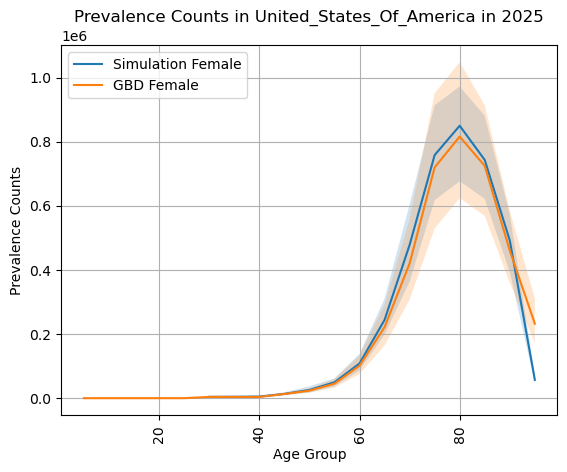

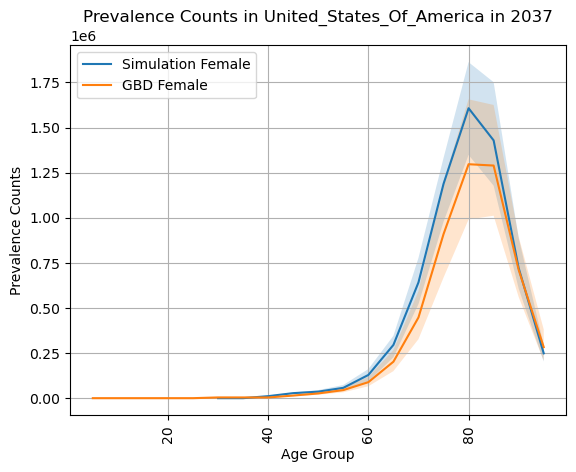

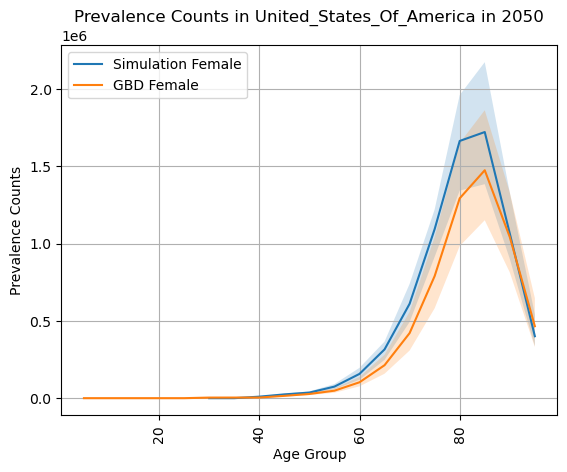

<Figure size 640x480 with 0 Axes>

In [69]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

# Dementia Prevalence

In [223]:
# swtich from this
# art.load(
#     'population.scaling_factor'
#         )#.droplevel(['year_start', 'year_end'])

# to this
# art.load(
#     'cause.alzheimers.prevalence'
#         )#.droplevel(['year_start', 'year_end'])

# ?

In [70]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.prevalence").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]


art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      55173.295736   
                                                  2047       2048      56569.197309   
                                                  2048       2049      58017.307994   
                                                  2049       2050      59455.918860   
                                                  2050       2051      60791.531100   

                                                                             draw_1  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      62960.360100   
                                                  2047       2048      64778.886343   
                                                  2048       2049      66721.023153   
                                                  2049       2050      68637.274127   
                                                  2050       2051      70358.671211   

                                                                             draw_2  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      53415.859578   
                                                  2047       2048      54902.012715   
                                                  2048       2049      56443.222505   
                                                  2049       2050      57958.095674   
                                                  2050       2051      59376.361251   

                                                                             draw_3  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                     

In [225]:
# t[t.sub_entity == 'alzheimers_disease_state']

In [71]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")

# restrict to dementia state only
new_sims = new_sims[new_sims.sub_entity == "alzheimers_disease_state"]

new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,322011.751909,48547.868485,252310.072411,258115.002787,318072.030148,411866.623495,429755.620204,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,541696.480414,101597.166462,386886.345641,391497.586109,534189.860588,732140.711739,785300.792452,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,203233.610325,37611.312357,145286.778572,145515.705404,202572.992896,259537.619527,264083.452329,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,215842.028115,58343.411044,142615.965535,144103.989942,197013.341268,329022.363599,331017.297419,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,74590.902548,20080.513546,45785.366348,49709.826321,67860.453694,109628.699209,110593.462286,24,235,95 plus,95.0,125.0


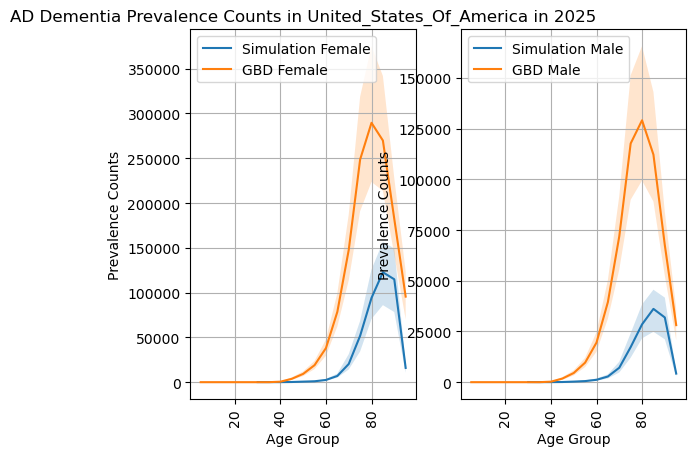

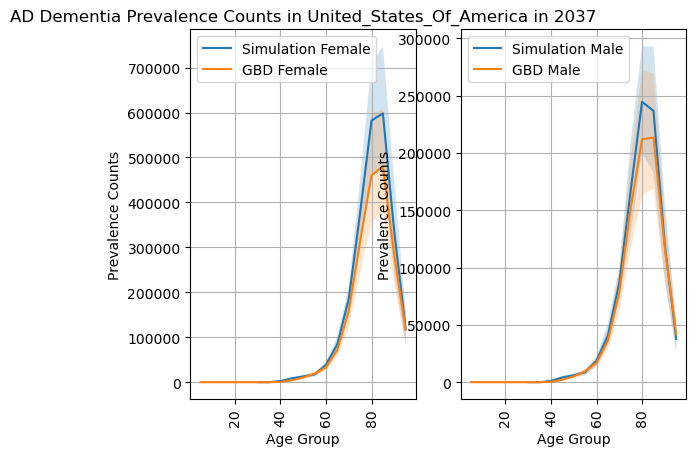

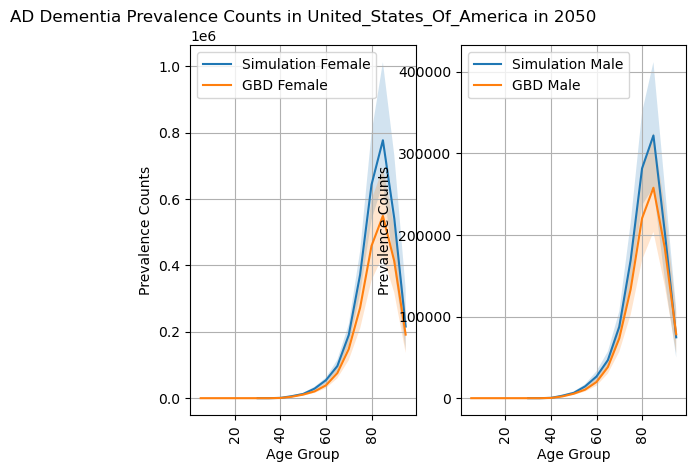

<Figure size 640x480 with 0 Axes>

In [72]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for i, sex in enumerate(new_sims.sex.unique()):
            plt.subplot(1, 2, i + 1)
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            if i == 0:
                plt.title(f"AD Dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

## Total Sim Population Over Time

In [73]:
cols = ["input_draw", "event_year", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,101457.687611,266.642232,100838.214921,100902.793155,101429.185489,101972.619302,102038.094456
1,2026,United_States_Of_America,25.0,108326.619247,1338.062934,105137.451061,105437.321287,108434.628337,110648.924298,111280.355921
2,2027,United_States_Of_America,25.0,114892.172704,2338.551230,109249.330595,109803.627105,114942.280630,118749.606023,120195.739904
3,2028,United_States_Of_America,25.0,121197.938289,3379.953705,113365.694730,113959.156742,121264.071184,126701.399042,129142.516085
4,2029,United_States_Of_America,25.0,127285.871923,4379.775713,117258.825462,117963.206571,127341.700205,134408.731554,137804.769336
...,...,...,...,...,...,...,...,...,...,...
71,2096,United_States_Of_America,25.0,190021.493662,15563.179675,161688.251882,162971.146338,187159.282683,221760.758932,235976.640657
72,2097,United_States_Of_America,25.0,189967.140315,15504.475811,161803.854894,163120.832307,187131.378508,221739.133196,235876.982888
73,2098,United_States_Of_America,25.0,189930.466256,15466.531235,161891.055441,163066.020534,187397.963039,221579.581109,235872.000000
74,2099,United_States_Of_America,25.0,189925.921862,15449.233173,162056.985626,163114.454209,187348.632444,221496.765503,235831.638604


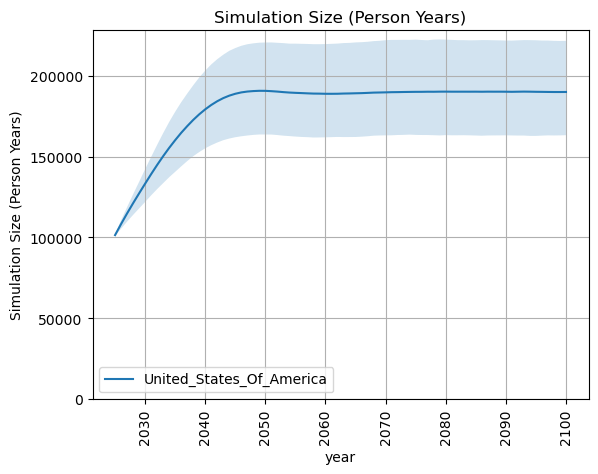

In [74]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data["mean"], label=location)
    plt.fill_between(
        plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
    )
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Decompose person-time by state

In [75]:
cols = ["input_draw", "event_year", "sub_entity", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

/tmp/ipykernel_800788/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_800788/4293227660.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_800788/4293227660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total.groupby([c for c

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,61909.299384,894.217705,59751.808350,60459.478166,61999.589322,63475.819849,63653.409993
1,2025,alzheimers_disease_state,United_States_Of_America,25.0,10262.757016,766.430025,8827.685147,9039.358248,10308.599589,11568.772074,11713.774127
2,2025,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,29285.631211,698.614627,28139.367556,28236.234908,29154.381930,30683.132101,31171.953457
3,2026,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,62698.828090,1290.142817,60189.305955,60295.142505,62661.316906,64780.340041,64886.176591
4,2026,alzheimers_disease_state,United_States_Of_America,25.0,16713.464860,651.435668,15584.481862,15678.060507,16641.352498,17873.222177,18087.885010
...,...,...,...,...,...,...,...,...,...,...,...
223,2099,alzheimers_disease_state,United_States_Of_America,25.0,76978.929281,9977.970042,63035.531828,63532.126489,75414.023272,96109.154825,101263.753593
224,2099,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,35936.013361,2876.549469,29726.417522,30145.578097,35721.330595,41657.545243,43231.041752
225,2100,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,77031.947214,5628.781526,63976.799452,66328.822450,76983.134839,86582.769062,91440.487337
226,2100,alzheimers_disease_state,United_States_Of_America,25.0,77010.520794,9955.176161,63210.431211,63687.293634,75458.869268,96211.403696,101174.061602


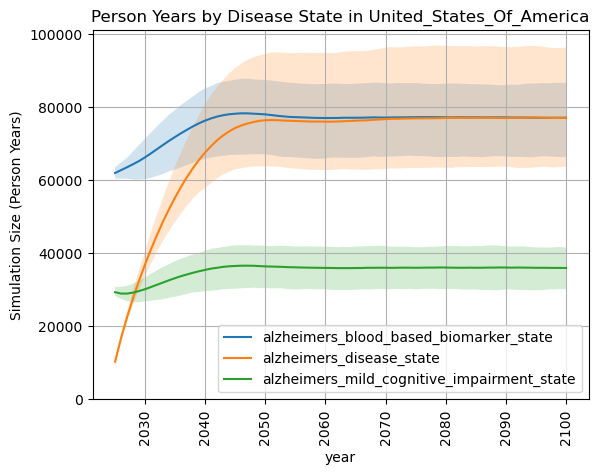

In [76]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Does this mean that excess mortality is too low??
# I don't think that is the main problem --- more important to figure out what the AD Dementia prevalence is missing its target on initialization
